In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

## Helping Robots

In [ ]:
import gc
import os
import logging
import datetime
import warnings
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')

All through modelling the algo i was looking for chances to improve my score. Got inspired by the words of **@swagatron** to check the distribution of the results. So it was really great to go back to the drawing board and check the distribution as mentioned by **@donkeys** and **@ninoko**

The leaderboard distributions are given in the discussion threads :

* https://www.kaggle.com/c/career-con-2019/discussion/84760
* https://www.kaggle.com/c/career-con-2019/discussion/85204

In [ ]:
train = pd.read_csv('../input/X_train.csv')
test = pd.read_csv('../input/X_test.csv')
target = pd.read_csv('../input/y_train.csv')
submission = pd.read_csv('../input/sample_submission.csv')

In [ ]:
train.head()

In [ ]:
# No null values
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

There are no null values in the dataset

In [ ]:
#checking the Target distribution
plt.figure(figsize=(15,5))
sns.countplot(y=target['surface'],order=target.surface.value_counts().index)

If we look at the above graph, the information for hard tiles is very less

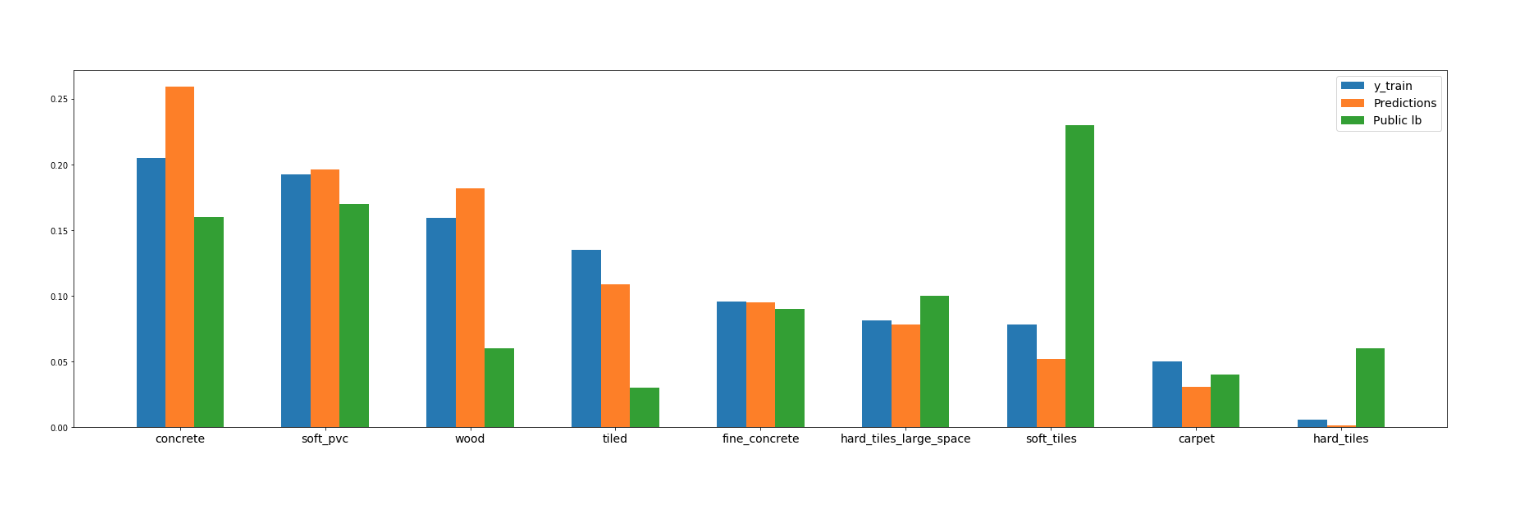

Comparing with the leaderboard, we have a different distribution. This chances of increasing the score is to have a distribution similar to leaderboard score. The main difference which i noticed in the leaderboard is that:

* There is significant amount of records for **hard_tiles** in leaderboard
* For soft_tiles there are high predictions

In [ ]:
train.info()

The idea of reducing memory usage of the kernel was borrowed from **@swagatron**. Thanks for this, a new tip to use

In [ ]:
def reduce_mem_usage(df):
    # iterate through all the columns of a dataframe and modify the data type
    #   to reduce memory usage.        
    
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [ ]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

In [ ]:
train.info()

In [ ]:
len(target.series_id.unique())

In [ ]:
print('There are {} rows and {} columns for training set'.format(train.shape[0],train.shape[1]))
print('There are {} rows and {} columns for test set'.format(test.shape[0],test.shape[1]))
print('There are {} rows and {} columns for test set'.format(target.shape[0],target.shape[1]))

In [ ]:
len(train['series_id'].value_counts())

The input data, is covering 10 sensor channels and 128 measurements per time series. 

The orientation channels encode the current angles how the robot is oriented as a quaternion (see Wikipedia). Angular velocity describes the angle and speed of motion, and linear acceleration components describe how the speed is changing at different times.

In [ ]:
len(test.series_id.unique())

In [ ]:
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(train.iloc[:,3:].corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

There is strong correlatiom between:
* orientation_X and orientation_W
* orientation_Y and orientation_Z
* orientation_Z and orientation_Y


### EDA

In [ ]:
def plot_feature_distribution(df1, df2, label1, label2, features,a=2,b=5):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(a,b,figsize=(17,9))

    for feature in features:
        i += 1
        plt.subplot(a,b,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show();

In [ ]:
features = train.columns.values[3:]
plot_feature_distribution(train, test, 'train', 'test', features)

Most of the features follow a normal distribution pattern, but there are overlap of guassians. orientation_X , orientation_Y and linear_acceleration_Y have some variation. We can try to apply standard scaler function for the same

In [ ]:
def plot_feature_class_distribution(classes,tt, features,a=5,b=2):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(a,b,figsize=(16,24))

    for feature in features:
        i += 1
        plt.subplot(a,b,i)
        for clas in classes:
            ttc = tt[tt['surface']==clas]
            sns.kdeplot(ttc[feature], bw=0.5,label=clas)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show();

In [ ]:
def create_valid_set(label):
    # Lets try creating a validation set of 10% of the total size.
    ldict = {
        'concrete': 0.16,
        'soft_pvc': 0.18,
        'wood': 0.06,
        'tiled': 0.03,
        'fine_concrete': 0.10,
        'hard_tiles_large_space': 0.12,
        'soft_tiles': 0.23,
        'carpet': 0.05,
        'hard_tiles': 0.07,
    }
    score = 0
    print("Required count of target classes for the Valid Set :: ")
    for key, value in ldict.items():
        score += value
        print(key,':',value)

In [ ]:
classes = (target['surface'].value_counts()).index
aux = train.merge(target, on='series_id', how='inner')
plot_feature_class_distribution(classes, aux, features)

Not all the surfaces follow the normal distribution pattern

In [ ]:
#create_valid_set(target)

In [ ]:
train.describe().T

In [ ]:
test.describe().T

In [ ]:
# checking the difference between train series id and test series id
diff = (test.shape[0]-train.shape[0])/128
print('Test has',diff,' extra series')

In [ ]:
train.columns

In [ ]:
# https://stackoverflow.com/questions/53033620/how-to-convert-euler-angles-to-quaternions-and-get-the-same-euler-angles-back-fr?rq=1
def quaternion_to_euler(x, y, z, w):
    import math
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

In [ ]:
def fe_step0 (actual):
    
    # https://www.mathworks.com/help/aeroblks/quaternionnorm.html
    # https://www.mathworks.com/help/aeroblks/quaternionmodulus.html
    # https://www.mathworks.com/help/aeroblks/quaternionnormalize.html
        
    actual['norm_quat'] = (actual['orientation_X']**2 + actual['orientation_Y']**2 + actual['orientation_Z']**2 + actual['orientation_W']**2)
    actual['mod_quat'] = (actual['norm_quat'])**0.5
    actual['norm_X'] = actual['orientation_X'] / actual['mod_quat']
    actual['norm_Y'] = actual['orientation_Y'] / actual['mod_quat']
    actual['norm_Z'] = actual['orientation_Z'] / actual['mod_quat']
    actual['norm_W'] = actual['orientation_W'] / actual['mod_quat']
    
    return actual

In [ ]:
%%time
train = fe_step0(train)
test = fe_step0(test)

In [ ]:
print(train.shape)
train.head()

In [ ]:
test.head()

In [ ]:
def fe_step1 (actual):
    """Quaternions to Euler Angles"""
    
    x, y, z, w = actual['norm_X'].tolist(), actual['norm_Y'].tolist(), actual['norm_Z'].tolist(), actual['norm_W'].tolist()
    nx, ny, nz = [], [], []
    for i in range(len(x)):
        xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
        nx.append(xx)
        ny.append(yy)
        nz.append(zz)
    
    actual['euler_x'] = nx
    actual['euler_y'] = ny
    actual['euler_z'] = nz
    return actual

In [ ]:
train = fe_step1(train)
test = fe_step1(test)
print(train.shape)
train.head()
#test.head()

**@Nanashi** had a good explanation on why Euler angles are really important, and we have a problem with Z?

Why Orientation_Z (euler angle Z) is so important?
We have a robot moving around, imagine a robot moving straight through different surfaces (each with different features), for example concrete and hard tile floor. Our robot can can bounce or balance itself a little bit on if the surface is not flat and smooth, that's why we need to work with quaternions and take care of orientation_Z.



In [ ]:
len(test['series_id'].unique())

In [ ]:
sns.countplot(y='surface',data=target)

In [ ]:
def total_values_fe(data):
    data['totl_anglr_vel'] = (data['angular_velocity_X']**2 + data['angular_velocity_Y']**2 +
                             data['angular_velocity_Z'])** 0.5
    data['totl_linr_acc'] = (data['linear_acceleration_X']**2 + data['linear_acceleration_Y']**2 +
                             data['linear_acceleration_Z'])**0.5
    data['totl_xyz'] = (data['orientation_X']**2 + data['orientation_Y']**2 +
                             data['orientation_Z'])**0.5
    #Lets derive one more column since there is a relationship in velocity and acceleration
    # v = u + a*t , u is initial velocty. if u = 0, then v = at means t = v/a
    # but value of acceleration is more and value of velocity is less, lets do a/v relation
    data['acc_vs_vel'] = data['totl_linr_acc'] / data['totl_anglr_vel']
    return data

In [ ]:
data = total_values_fe(train)
test = total_values_fe(test)
print(data.shape)
data.head()

In [ ]:
def mean_change_of_abs_change(x):
        return np.mean(np.diff(np.abs(np.diff(x))))

In [ ]:
len(test['series_id'].unique())

In [ ]:
train_data = pd.DataFrame()
test_data = pd.DataFrame()

In [ ]:
%%time
# columns for max, min, mean, median, abs_max, std, quartile(25%), quartile(50%), quartile(75%))
# starting from the Orientation column
columns = data.columns
for i in columns[1:]:
    if i in ['row_id','series_id','measurement_number']:
        continue
    train_data[i+'_max'] = data.groupby(by='series_id')[i].max()
    test_data[i+'_max'] = test.groupby(by='series_id')[i].max()
    print(i)
    train_data[i+'_min'] = data.groupby(by='series_id')[i].min()
    test_data[i+'_min'] = test.groupby(by='series_id')[i].min()
        
    train_data[i+'_mean'] = data.groupby(by='series_id')[i].mean()
    test_data[i+'_mean'] = test.groupby(by='series_id')[i].mean()
        
    train_data[i+'_median'] = data.groupby(by='series_id')[i].median()
    test_data[i+'_median'] = test.groupby(by='series_id')[i].median()
        
    train_data[i+'_quantile_25'] = data.groupby(by='series_id')[i].quantile(0.25)
    test_data[i+'_quantile_25'] = test.groupby(by='series_id')[i].quantile(0.25)
        
    train_data[i+'_quantile_50'] = data.groupby(by='series_id')[i].quantile(0.5)
    test_data[i+'_quantile_50'] = test.groupby(by='series_id')[i].quantile(0.5)
        
    train_data[i+'_quantile_75'] = data.groupby(by='series_id')[i].quantile(0.75)
    test_data[i+'_quantile_75'] = test.groupby(by='series_id')[i].quantile(0.75)
    
    #train_data[col + '_mean_change_of_abs_change'] = train.groupby('series_id')[col].apply(mean_change_of_abs_change)
    train_data[i+'_abs_max'] = data.groupby(by='series_id')[i].apply(lambda x: np.max(np.abs(x)))
    test_data[i+'_abs_max'] = test.groupby(by='series_id')[i].apply(lambda x: np.max(np.abs(x)))
    
    train_data[i + '_mean_abs_chg'] = data.groupby(['series_id'])[i].apply(lambda x: np.mean(np.abs(np.diff(x))))
    test_data[i + '_mean_abs_chg'] = test.groupby(['series_id'])[i].apply(lambda x: np.mean(np.abs(np.diff(x))))
    
    train_data[i + '_mean_change_of_abs_change'] = data.groupby('series_id')[i].apply(mean_change_of_abs_change)
    test_data[i + '_mean_change_of_abs_change'] = test.groupby('series_id')[i].apply(mean_change_of_abs_change)
    
    train_data[i + '_abs_min'] = data.groupby(['series_id'])[i].apply(lambda x: np.min(np.abs(x)))
    test_data[i + '_abs_min'] = test.groupby(['series_id'])[i].apply(lambda x: np.min(np.abs(x)))
    
    train_data[i + '_abs_avg'] = (train_data[i + '_abs_min'] + train_data[i + '_abs_max'])/2
    test_data[i + '_abs_avg'] = (test_data[i + '_abs_min'] + test_data[i + '_abs_max'])/2
        
    train_data[i+'_std'] = data.groupby(by='series_id')[i].std()
    test_data[i+'_std'] = test.groupby(by='series_id')[i].std()
         
    train_data[i + '_range'] = train_data[i + '_max'] - train_data[i + '_min']
    test_data[i + '_range'] = test_data[i + '_max'] - test_data[i + '_min']
        
    train_data[i + '_maxtoMin'] = train_data[i + '_max'] / train_data[i + '_min']
    test_data[i + '_maxtoMin'] = test_data[i + '_max'] / test_data[i + '_min']


In [ ]:
print(train_data.shape)
train_data.head()

In [ ]:
# It seems no NaN values
train_data.isnull().values.any()

In [ ]:
# There is missing data, we shall replace the same by zeroes
train_data.fillna(0,inplace=True)
train_data.replace(-np.inf,0,inplace=True)
train_data.replace(np.inf,0,inplace=True)
test_data.fillna(0,inplace=True)
test_data.replace(-np.inf,0,inplace=True)
test_data.replace(np.inf,0,inplace=True)

In [ ]:
train_data.isnull().values.any()

In [ ]:
#label Encoding
le = LabelEncoder()
target['surface'] = le.fit_transform(target['surface'])

In [ ]:
target['surface'].value_counts()

In [ ]:
# Using RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [ ]:
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
predicted = np.zeros((test_data.shape[0],9)) # we have 9 labels
measured= np.zeros((train_data.shape[0]))
score = 0

In [ ]:
for times, (trn_idx,val_idx) in enumerate(folds.split(train_data.values,target['surface'].values)):
    rf = RandomForestClassifier(n_estimators=500,n_jobs = -1)
    rf.fit(train_data.iloc[trn_idx],target['surface'][trn_idx])
    measured[val_idx] = rf.predict(train_data.iloc[val_idx])
    predicted += rf.predict_proba(test_data)/folds.n_splits
    score += rf.score(train_data.iloc[val_idx],target['surface'][val_idx])
    print("Fold: {} score: {}".format(times,rf.score(train_data.iloc[val_idx],target['surface'][val_idx])))
    gc.collect()

In [ ]:
 print('Avg. accuracy',score /folds.n_splits)

In [ ]:
def plot_confusion_matrix(truth, pred, classes, normalize=False, title=''):
    cm = confusion_matrix(truth, pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix', size=15)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.tight_layout()

In [ ]:
plot_confusion_matrix(target['surface'], measured, le.classes_)

In [ ]:
submission['surface'] = le.inverse_transform(predicted.argmax(axis=1))
submission.to_csv('submission_92.csv',index=False)
submission.head()

In [ ]:
submission.head(20)